In [1]:
import pandas as pd
import ms3 
from  ms3.utils import *
import os 
from ms3 import Score
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

### Convert midi to mscx  
Convert a folder of midi files to the mscx format

In [ ]:
home_dir = '/Users/Pushkar/PycharmProjects/Tresillo'

In [90]:
path_midi = home_dir + '/dataset/project_midi/tresillo/'
target = home_dir + '/dataset/project_mscx/mscx_tresillos_billboard/'

dir_list = os.listdir(path_midi)

for el in dir_list:
    convert(path_midi+el, target+el[:-4]+'.mscx', MS='musescore3')

INFO     root -- utils.py (line 427) convert():
	Converted /home/nulpe/Desktop/Tresillo/dataset/project_midi/tresillo/Cheap Thrills(feat. Sean Paul)-Sia, Sean Paul.mid to /home/nulpe/Desktop/Tresillo/dataset/project_mscx/mscx_tresillos_billboard/Cheap Thrills(feat. Sean Paul)-Sia, Sean Paul.mscx
INFO     root -- utils.py (line 427) convert():
	Converted /home/nulpe/Desktop/Tresillo/dataset/project_midi/tresillo/New rules-Dua Lipa.mid to /home/nulpe/Desktop/Tresillo/dataset/project_mscx/mscx_tresillos_billboard/New rules-Dua Lipa.mscx
INFO     root -- utils.py (line 427) convert():
	Converted /home/nulpe/Desktop/Tresillo/dataset/project_midi/tresillo/Let Me Love You ft Justin Bieber-DJ Snake, Justin Bieber.mid to /home/nulpe/Desktop/Tresillo/dataset/project_mscx/mscx_tresillos_billboard/Let Me Love You ft Justin Bieber-DJ Snake, Justin Bieber.mscx
INFO     root -- utils.py (line 427) convert():
	Converted /home/nulpe/Desktop/Tresillo/dataset/project_midi/tresillo/Willow-Taylor Swift.mid

### Mscx to rythm vectors including all instruments
Convert a folder of mscx files to a data frame of rythm vectors.  
Attetion: Every instrument has it's own rythm vector. To obtain oe rythm vector per song colapse per artist_song 

In [75]:
def rythm_vectors(in_dir, out_dir):
    list_sheet_music = os.listdir(in_dir)
    df_rythm_vectors =[]

    for idx, el in enumerate(list_sheet_music):
        if el[-4:] == 'mscx':

            
            #Get notes with onsets
            s = Score(dir_sheet_music+el)
            df = s.mscx.notes

            # Define instruments 
            instrument_dict = {}
            for key in s.mscx.metadata['parts']:
                for staff in s.mscx.metadata['parts'][key].keys():
                    instrument_dict[staff] = key


            #staff to instruments 
            df['instrument'] = [instrument_dict[el] if el in instrument_dict else 'na' for el in df.staff]


            # define quarter beat 
            df['quarter_beats'] = (df.mc_onset*16).astype('int32')


            #make rythm matrix & data frame
            df_histogram = df.groupby(['instrument','quarter_beats'])['mn'].agg(['count'])
            df_histogram = df_histogram.groupby(level=0).apply(lambda x: x.reset_index(level = 0).drop(['instrument'],axis=1).reindex(list(range(0,16)),fill_value=0).T)
            df_histogram = df_histogram.reset_index()

            df_histogram.insert(loc=0, column='song_artist', value=el[:-5])

            #concat to big rythm vector df
            if len(df_rythm_vectors) == 0: df_rythm_vectors = df_histogram

            df_rythm_vectors = pd.concat([df_rythm_vectors,df_histogram], axis=0)

    df_rythm_vectors.to_csv(out_dir, index = False)

    
dir_sheet_music = home_dir + '/dataset/project_mscx/mscx_billboard/'
out_dir = home_dir + '/dataset/rythm_vectors/rythm_vectors_billboard.csv'
rythm_vectors(dir_sheet_music, out_dir)

In [107]:
df_rythm_vectors = pd.read_csv(home_dir + '/dataset/rythm_vectors/rythm_vectors_tresillos_billboard.csv')
df_rythm_vectors

,song_artist,instrument,level_1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,"Eastside-benny blanco, Halsey, Khalid",Athmosphere,count,32,0,0,0,0,0,0,0,30,0,0,0,30,0,0,0
1,"Eastside-benny blanco, Halsey, Khalid",Bright Piano,count,64,0,0,0,0,0,0,0,32,0,0,0,60,0,0,0
2,"Eastside-benny blanco, Halsey, Khalid",Fingered Bass,count,16,0,0,16,16,0,0,0,15,0,0,15,15,0,7,0
3,"Eastside-benny blanco, Halsey, Khalid",Jazz Guitar,count,48,0,0,0,0,0,0,0,45,0,0,0,45,0,0,0
4,"Eastside-benny blanco, Halsey, Khalid",Nylon Gtr.,count,48,0,0,0,0,0,0,0,45,0,0,0,45,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,Taylor Swift_willow,Gtr.Harmonics,count,12,0,0,4,0,0,4,0,4,0,0,3,0,0,3,0
95,Taylor Swift_willow,Ocarina,count,12,0,0,4,0,0,4,0,4,0,0,3,0,0,3,0
96,Taylor Swift_willow,Percussion,count,0,0,3,0,0,0,4,0,0,0,3,0,0,0,3,0
97,Taylor Swift_willow,Slap Bass 1,count,75,0,0,20,0,0,20,0,60,0,5,20,5,0,15,0


### Calculate cosine similarity between tresillo vecetors and songs 

In [90]:
def collapse_normalize_vectors(df_rythm_vectors):
    rythm_vector_collaped = df_rythm_vectors.groupby(['song_artist']).agg(['sum'])
    rythm_vector_collaped.columns = rythm_vector_collaped.columns.droplevel(1)
    rythm_vector_collaped = rythm_vector_collaped.drop(['instrument', 'level_1'],axis=1)
    rythm_vector_collaped["sum"] = rythm_vector_collaped.sum(axis=1)
    rythm_vector_collaped = rythm_vector_collaped.loc[:,"0":"15"].div(rythm_vector_collaped["sum"], axis=0)
    return rythm_vector_collaped

def calc_cosine_sim(rythm_vectors, tresillo_vector):
    rythm_vectors['cosine_sim_tresillo'] = cosine_similarity(rythm_vectors.loc[:,"0":"15"],tresillo_vector)
    return rythm_vectors

In [91]:
# the billboard tresillo vectors 
df_rythm_vectors = pd.read_csv(home_dir + '/dataset/rythm_vectors/rythm_vectors_tresillos_billboard.csv')
rythm_vector_collaped = collapse_normalize_vectors(df_rythm_vectors)
rythm_vector_collaped

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
song_artist,,,,,,,,,,,,,,,,
"Cheap Thrills(feat. Sean Paul)-Sia, Sean Paul",0.211900,0.007307,0.015136,0.102296,0.062109,0.000000,0.105428,0.000000,0.199374,0.008873,0.016701,0.103862,0.067328,0.001566,0.096033,0.002088
"Eastside-benny blanco, Halsey, Khalid",0.221595,0.006351,0.019054,0.064220,0.042343,0.014820,0.052929,0.010586,0.172900,0.007763,0.019760,0.062103,0.187721,0.022583,0.062809,0.032463
"Let Me Love You ft Justin Bieber-DJ Snake, Justin Bieber",0.151248,0.004607,0.122073,0.013820,0.119386,0.004607,0.099808,0.002687,0.110173,0.003071,0.101727,0.007678,0.122073,0.008829,0.116699,0.011516
New rules-Dua Lipa,0.176933,0.020533,0.050240,0.092180,0.061162,0.014417,0.050677,0.010922,0.097859,0.015291,0.076453,0.121014,0.082569,0.015291,0.102665,0.011796
"Rockabye-Clean Bandit, Sean Paul, Anne-Marie",0.183642,0.003086,0.052469,0.075617,0.043981,0.008488,0.075617,0.037037,0.154321,0.033951,0.038580,0.090278,0.053241,0.023148,0.105710,0.020833
Shape of you-Ed Sheran,0.148522,0.023792,0.031723,0.085797,0.051911,0.026676,0.121846,0.008652,0.144196,0.020908,0.054074,0.080750,0.054074,0.019466,0.120404,0.007210
Taylor Swift_willow,0.299113,0.000000,0.003802,0.081115,0.070976,0.000000,0.086185,0.000000,0.221800,0.000000,0.019011,0.076046,0.077313,0.000000,0.064639,0.000000
The+Chainsmokers+-+Don't+Let+Me+Down,0.181953,0.000000,0.029586,0.005917,0.125740,0.000000,0.100592,0.000000,0.170118,0.000000,0.059172,0.047337,0.184911,0.000000,0.094675,0.000000
Treat you better-Shawn Mendes,0.150000,0.023656,0.036559,0.086559,0.064516,0.024731,0.085484,0.023118,0.138710,0.023118,0.029570,0.087634,0.067204,0.032796,0.095699,0.030645


In [92]:
# the self defined synthetique tresillo vectors 
df_synt_tresillo = pd.read_csv(home_dir + '/dataset/rythm_vectors/rythm_vectors_tresillio.csv')
df_synt_tresillo = df_synt_tresillo[df_synt_tresillo['song_artist']!='Raggetone'].drop(['instrument','level_1'], axis=1)
df_synt_tresillo.index = df_synt_tresillo.song_artist
df_synt_tresillo.drop(['song_artist'], axis=1)
df_synt_tresillo["sum"] = df_synt_tresillo.sum(axis=1)
df_synt_tresillo = df_synt_tresillo.loc[:,"0":"15"].div(df_synt_tresillo["sum"], axis=0)
tresillo_vector = df_synt_tresillo.sum()/len(df_synt_tresillo)
tresillo_vector = np.asarray(tresillo_vector).reshape(-1, 1).T

In [93]:
# all synthetique tresillos collapsed together, not very convincing results, it seems it averages the effect out, especially if you compare it to not tresillo songs
rythm_vector_collaped = calc_cosine_sim(rythm_vector_collaped, tresillo_vector)
rythm_vector_collaped['cosine_sim_tresillo']

song_artist
Cheap Thrills(feat. Sean Paul)-Sia, Sean Paul               0.913635
Eastside-benny blanco, Halsey, Khalid                       0.803275
Let Me Love You ft Justin Bieber-DJ Snake, Justin Bieber    0.774479
New rules-Dua Lipa                                          0.926529
Rockabye-Clean Bandit, Sean Paul, Anne-Marie                0.915665
Shape of you-Ed Sheran                                      0.964258
Taylor Swift_willow                                         0.828289
The+Chainsmokers+-+Don't+Let+Me+Down                        0.779599
Treat you better-Shawn Mendes                               0.940530
Willow-Taylor Swift                                         0.903536
Name: cosine_sim_tresillo, dtype: float64

In [94]:
# not tresillo songs vectors
df_rythm_vectors = pd.read_csv(home_dir + '/dataset/rythm_vectors/rythm_vectors_no_tresillos_4_4.csv')
non_tresillio_vectors = collapse_normalize_vectors(df_rythm_vectors)
non_tresillio_vectors = calc_cosine_sim(non_tresillio_vectors, tresillo_vector)
non_tresillio_vectors['cosine_sim_tresillo']

song_artist
A hard days night-Beatles               0.794264
Cocaine-Eric Clapton                    0.789114
Come together-Beatles                   0.778343
Come_As_You_Are-Nirvana                 0.771313
Crazy little thing called love-Queen    0.718345
Hey Jude- Beatles                       0.697940
I Shot the Sheriff-Eric Clapton         0.909999
Walk of Life- Dire Straits              0.708941
Name: cosine_sim_tresillo, dtype: float64

In [95]:
#lets compare all self defined tresillos to tresillo billboard songs and not tresillo billboard songs ---> vanilla tresillo reflects the most our intuition
for index in df_synt_tresillo.index:
    print('\n')
    print(index)
    vector = np.asarray(df_synt_tresillo.loc[index,"0":"15"]).reshape(-1, 1).T
    print('tresillio songs')
    print(calc_cosine_sim(rythm_vector_collaped, vector)['cosine_sim_tresillo'])
    print('no tresillio songs')
    print(calc_cosine_sim(non_tresillio_vectors, vector)['cosine_sim_tresillo'])



Cinquillo
tresillio songs
song_artist
Cheap Thrills(feat. Sean Paul)-Sia, Sean Paul               0.732785
Eastside-benny blanco, Halsey, Khalid                       0.616876
Let Me Love You ft Justin Bieber-DJ Snake, Justin Bieber    0.691407
New rules-Dua Lipa                                          0.808246
Rockabye-Clean Bandit, Sean Paul, Anne-Marie                0.804314
Shape of you-Ed Sheran                                      0.842578
Taylor Swift_willow                                         0.645638
The+Chainsmokers+-+Don't+Let+Me+Down                        0.587273
Treat you better-Shawn Mendes                               0.815995
Willow-Taylor Swift                                         0.785162
Name: cosine_sim_tresillo, dtype: float64
no tresillio songs
song_artist
A hard days night-Beatles               0.698336
Cocaine-Eric Clapton                    0.647976
Come together-Beatles                   0.676899
Come_As_You_Are-Nirvana                 0.645211
C

In [96]:
#vanilla tresillo reflects the most our intuition
vanilla_tresillo_vector = np.asarray(df_synt_tresillo.loc['Vanilla_Tresillo',"0":"15"]).reshape(-1, 1).T

print('tresillio songs')
print(calc_cosine_sim(rythm_vector_collaped, vanilla_tresillo_vector)['cosine_sim_tresillo'])
print('no tresillio songs')
print(calc_cosine_sim(non_tresillio_vectors, vanilla_tresillo_vector)['cosine_sim_tresillo'])

tresillio songs
song_artist
Cheap Thrills(feat. Sean Paul)-Sia, Sean Paul               0.908945
Eastside-benny blanco, Halsey, Khalid                       0.711226
Let Me Love You ft Justin Bieber-DJ Snake, Justin Bieber    0.605146
New rules-Dua Lipa                                          0.838867
Rockabye-Clean Bandit, Sean Paul, Anne-Marie                0.880677
Shape of you-Ed Sheran                                      0.915565
Taylor Swift_willow                                         0.811188
The+Chainsmokers+-+Don't+Let+Me+Down                        0.660548
Treat you better-Shawn Mendes                               0.883772
Willow-Taylor Swift                                         0.760835
Name: cosine_sim_tresillo, dtype: float64
no tresillio songs
song_artist
A hard days night-Beatles               0.639260
Cocaine-Eric Clapton                    0.656375
Come together-Beatles                   0.626717
Come_As_You_Are-Nirvana                 0.619208
Crazy little 

### Use bootstrapping to obtain upper and lower 97.5% confidence interval 

In [97]:
def bootstrap_CI(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]


In [98]:
lower_tresillo_ci, upper_tresillo_ci = bootstrap_CI(calc_cosine_sim(rythm_vector_collaped, vanilla_tresillo_vector)['cosine_sim_tresillo'], 100)
lower_no_tresillo_ci, upper_no_tresillo_ci = bootstrap_CI(calc_cosine_sim(non_tresillio_vectors, vanilla_tresillo_vector)['cosine_sim_tresillo'], 100)

mean_tresillo = calc_cosine_sim(rythm_vector_collaped, vanilla_tresillo_vector)['cosine_sim_tresillo'].mean()
mean_no_tresillo = calc_cosine_sim(non_tresillio_vectors, vanilla_tresillo_vector)['cosine_sim_tresillo'].mean()
print('tresillio songs mean tresillo-ness: ', mean_tresillo)
print('tresillo upper and lower ci on 100 draws: ', lower_tresillo_ci, upper_tresillo_ci)
print('\n')
print('no tresillio songs mean tresillo-ness: ', mean_no_tresillo)
print('no tresillo upper and lower ci on 100 draws: ', lower_no_tresillo_ci, upper_no_tresillo_ci)

tresillio songs mean tresillo-ness:  0.7976769323047527
tresillo upper and lower ci on 100 draws:  0.747394722630662 0.8692083030025545


no tresillio songs mean tresillo-ness:  0.63573893650337
no tresillo upper and lower ci on 100 draws:  0.5985942170845163 0.689589142884443


In [99]:
df_synt_tresillo = pd.read_csv(home_dir + '/dataset/rythm_vectors/rythm_vectors_tresillio.csv')
df_synt_raggeton = collapse_normalize_vectors(df_synt_tresillo[df_synt_tresillo['song_artist']=='Raggetone'])
raeggeton_sim = calc_cosine_sim(df_synt_raggeton, vanilla_tresillo_vector)
raeggeton_sim

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,cosine_sim_tresillo
song_artist,,,,,,,,,,,,,,,,,
Raggetone,0.2,0.0,0.0,0.1,0.1,0.0,0.1,0.0,0.2,0.0,0.0,0.1,0.1,0.0,0.1,0.0,0.872872


### Tresillio-ness in the billboards over time 

In [113]:
df_billboard = pd.read_csv(home_dir + '/dataset/rythm_vectors/rythm_vectors_billboard.csv')
df_billboard = collapse_normalize_vectors(df_billboard)

df_billboard_sim = calc_cosine_sim(df_billboard, vanilla_tresillo_vector)




df_billboard_sim['song_artist'] = df_billboard_sim.index
df_billboard_sim['song'] = df_billboard_sim.song_artist.apply(lambda x: x.split('_')[0])
df_billboard_sim['artist'] = df_billboard_sim.song_artist.apply(lambda x: x.split('_')[1][:-1])
df_billboard_sim = df_billboard_sim.drop(['song_artist'], axis=1)
#df_billboard_sim[df_billboard_sim['song']=='Shape Of You']
df_billboard_sim

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,cosine_sim_tresillo,song,artist
song_artist,,,,,,,,,,,,,,,,,,,
Shape Of You_Ed Sheeran.,0.148522,0.023792,0.031723,0.085797,0.051911,0.026676,0.121846,0.008652,0.144196,0.020908,0.054074,0.08075,0.054074,0.019466,0.120404,0.00721,0.915565,Shape Of You,Ed Sheeran


In [109]:
df_bill_board = pd.read_csv(home_dir + '/dataset/billboard_data_sets/billboard_1999-2019_unique_top_20_selection.csv')


df_bilboard_merged = df_billboard_sim.merge(df_bill_board, left_on=['song','artist'], right_on=['Name', 'Artists'], how='left')
df_bilboard_merged

,0,1,2,3,4,5,6,7,8,9,...,Name,Weekly.rank,Peak.position,Weeks.on.chart,Week,Date,Genre,Writing.Credits,Lyrics,Features
0,0.184416,0.012930,0.033345,0.018033,0.096632,0.012589,0.073835,0.066349,0.038108,0.036407,...,22,20.0,20.0,9.0,2013-05-10,"October 22, 2012","Pop Country,Pop-Rock,Dance-Pop,Country,Pop","Shellback, Max martin, Taylor swift",22 \nIt feels like a perfect night\nTo dress u...,NaN
1,0.189036,0.000000,0.035917,0.000000,0.085066,0.001890,0.134216,0.003781,0.128544,0.007561,...,3,1.0,1.0,1.0,2009-10-22,"October 2, 2009","Electronic,Dance,Electro-Pop,Pop","Tiffany amber, Shellback, Max martin","3 \n1, 2, 3\nNot only you and me\nGot one eigh...",NaN
2,0.194359,0.023174,0.084609,0.000000,0.158942,0.021863,0.085702,0.000000,0.109095,0.000000,...,50 Ways To Say Goodbye,20.0,20.0,15.0,2012-11-02,"June 11, 2012","Pop-Rock,Pop,Rock","Amund bjorklund, Espen lind, Patrick monahan",50 Ways to Say Goodbye \nMy heart is paralyzed...,NaN
3,0.079911,0.024417,0.042175,0.125416,0.120977,0.021088,0.088790,0.034406,0.120977,0.031077,...,7 Days,20.0,20.0,8.0,2002-01-22,"July 24, 2000","UK,R&;B,Pop","Darren hill, Mark hill, Craig david",7 Days \nYou know what?\nGot something to say\...,NaN
4,0.412073,0.002625,0.009186,0.001312,0.114173,0.001312,0.015748,0.005249,0.178478,0.005249,...,7 Years,20.0,20.0,5.0,2016-03-05,"June 16, 2015","Pop-Rock,Adult Alternative,Adult Contemporary,...","Morten pilo pilegaard, Lukas forchhammer, Mort...",7 Years \nOnce I was seven years old my momma ...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,0.143731,0.036697,0.050459,0.061162,0.077982,0.059633,0.047401,0.050459,0.114679,0.044343,...,You Found Me,15.0,15.0,2.0,2008-12-11,"November 21, 2008","Pop,Alternative Rock,Rock","Joe king, Isaac slade",You Found Me \nI found God on the corner of Fi...,NaN
438,0.141340,0.010617,0.045786,0.065693,0.100199,0.039814,0.069675,0.031851,0.184472,0.013935,...,You Rock My World,11.0,11.0,2.0,2001-09-11,"August 22, 2001","R&;B,Pop","Nora payne, Lashawn daniels, Fred jerkins iii,...","You Rock My World \nOh man! Look at that girl,...",NaN
439,0.210084,0.033613,0.062185,0.067227,0.052101,0.025210,0.055462,0.038655,0.072269,0.033613,...,You Sang To Me,18.0,18.0,8.0,2000-04-11,"February 20, 2000",Rock,"Cory rooney, Marc anthony",You Sang To Me \nI just wanted you to comfort ...,NaN
440,0.135930,0.020668,0.081876,0.012321,0.127186,0.025437,0.090620,0.004372,0.112480,0.023052,...,Youngblood,17.0,17.0,11.0,2018-08-25,"April 12, 2018","New Wave,Pop,Synth-Pop,Electro-Pop,Alternative...","Watt, Louis bell, Ali tamposi, Ashton irwin, C...","Youngblood \nRemember the words you told me\n""...",NaN


In [110]:
df_bilboard_merged_month = df_bilboard_merged.groupby(['Week'])['cosine_sim_tresillo'].agg(['mean']).reset_index()
#df_bilboard_merged_month['year'] = df_bilboard_merged_month['Week'].year
df_bilboard_merged_month['year'] =pd.DatetimeIndex(df_bilboard_merged_month['Week']).year

df_bilboard_merged_year = df_bilboard_merged_month.groupby(['year'])['mean'].agg(['mean']).reset_index()
df_bilboard_merged_year

,year,mean
0,1999,0.650151
1,2000,0.642349
2,2001,0.631174
3,2002,0.644242
4,2003,0.646173
5,2004,0.603797
6,2005,0.634611
7,2006,0.639039
8,2007,0.614523
9,2008,0.604520


INFO     matplotlib.category -- Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO     matplotlib.category -- Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


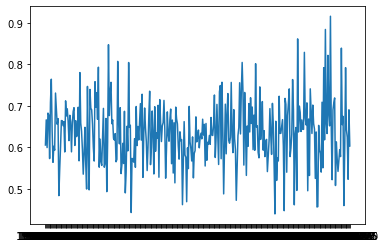

In [111]:
plt.plot(df_bilboard_merged_month.Week, df_bilboard_merged_month['mean'])

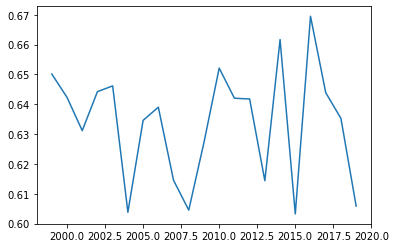

In [112]:
plt.plot(df_bilboard_merged_year.year, df_bilboard_merged_year['mean'])

In [117]:
df_bilboard_high_tresillo = df_bilboard_merged[df_bilboard_merged['cosine_sim_tresillo']>0.9]
df_bilboard_high_tresillo = df_bilboard_high_tresillo.drop(['0','1','2', '3', '4', '5', '6', 'Lyrics', 'Features'], axis =1)
df_bilboard_high_tresillo

,7,8,9,10,11,12,13,14,15,cosine_sim_tresillo,...,artist,Artists,Name,Weekly.rank,Peak.position,Weeks.on.chart,Week,Date,Genre,Writing.Credits
89,0.000000,0.199374,0.008873,0.016701,0.103862,0.067328,0.001566,0.096033,0.002088,0.908945,...,Sia,Sia,Cheap Thrills,19.0,19.0,16.0,2016-06-18,"February 10, 2016","Jamaica,Remix,Australia,Rap,Synth-Pop,Pop","Sean paul, Greg kurstin, Sia"
319,0.008652,0.144196,0.020908,0.054074,0.080750,0.054074,0.019466,0.120404,0.007210,0.915565,...,Ed Sheeran,Ed Sheeran,Shape Of You,1.0,1.0,1.0,2017-01-28,"January 6, 2017","Tropical House,Dancehall,Pop,UK","Lisa left eye lopes, Tameka tiny harris, Kandi..."
389,0.017930,0.118989,0.021190,0.019560,0.110024,0.039935,0.006520,0.097800,0.030155,0.937243,...,Kevin Lyttle,Kevin Lyttle,Turn Me On,20.0,20.0,6.0,2004-06-23,NaN,Pop,NaN
423,0.000000,0.151768,0.000000,0.023794,0.110611,0.043087,0.000643,0.129260,0.000000,0.947448,...,Rihanna,Rihanna,Where Have You Been,18.0,18.0,4.0,2012-05-25,"May 8, 2012","House,Electro-Pop,Pop","Geoff mack, Cirkut, Calvin harris, Dr luke, Es..."


In [114]:
df_bilboard_high_tresillo[df_bilboard_high_tresillo['artist']=='Ed Sheeran']

,0,1,2,3,4,5,6,7,8,9,...,Name,Weekly.rank,Peak.position,Weeks.on.chart,Week,Date,Genre,Writing.Credits,Lyrics,Features
